In [1]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate, integrate, optimize

https://stackoverflow.com/questions/77616590/how-to-put-variable-which-is-not-a-state-variable-in-a-odes-system-optimisation

![ODEs](https://i.sstatic.net/9kpsZ.png)
![Eqns](https://i.sstatic.net/IFpW3.png)


In [2]:
columns=['t', 'X', 'S', 'A', 'DO', 'V', 'F', 'kLa']
data = pd.read_csv(io.StringIO("""0,0.9,2,18.4,99,6250,18.9,121.956
1,1.3,1.2,18.59,64.7,6268.9,12.6,121.843
2,2.5,1.2,18.92,44.7,6281.5,26.6,122.069
3,4.4,1.0,19.53,45.2,6308.1,47.7,138.115
4,7.8,1.1,19.93,37.7,6355.8,88.2,150.356
5,12.8,1.1,20.73,36,6444.0,116.8,164.471
6,21,1.0,22.15,37.6,6560.8,188.6,176.819
6.5,26,0.9,23.26,42.5,6655.1,139.2,185.219
7,29,0.9,24.54,37.8,6724.7,73.2,187.883
8,35,0,22.83,57.8,6797.9,60.8,192.626
9,44,0,21.01,46.4,6858.7,74.0,192.626
10,52,0,18.76,44,6932.7,75.6,192.678
11,58,0,17.2,49.8,7008.3,67.2,192.739
12,65,0,15.67,66.9,7075.5,53.2,192.709
13,72,0,14.63,83,7128.7,39.2,192.709
14,75,0,14.09,89.8,7167.9,36.4,192.791
14.5,76,0,13.93,92.3,7186.1,25.2,192.804
15,76,0,13.84,92.9,7198.7,25.2,192.722"""), names=columns)

In [3]:
data = data.set_index("t")

In [4]:
#data["V"] /= 1000.
#data["X"] /= 100.
#data["DO"] /= 100.

In [5]:
#data /= data.max()

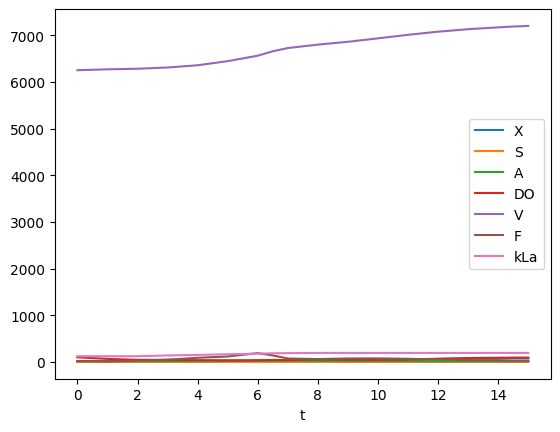

In [6]:
axe = data.plot()

In [7]:
def eqn_system(x, X, S, A, DO, V, Kap, Ksa, Ko, Ks, Kia, Kis, p_Amax, q_Amax, qm, q_Smax, Yoa, Yxa, Yem, Yos, Yxsof):
    qs, qsof, qsox, qsa, qo, mu = x
    return np.array([
         qs - (q_Smax * S / (S + Ks)) * Kia / (Kia + A),
         qsof - (p_Amax * qs / (qs + Kap)),
         qsox - (qs - qsof) * DO / (DO + Ko),
         qsa - (q_Amax * A / (A + Ksa)) * (Kis / (qs + Kis)),
         qo - (qsox - qm) * Yos + qsa * Yoa,
         mu - (qsox - qm) * Yem + qsof * Yxsof + qsa * Yxa,
    ])

In [8]:
reg_F = interpolate.interp1d(data.index, data.iloc[:,5])
reg_kLa = interpolate.interp1d(data.index, data.iloc[:,6])

In [9]:
def ode_system(t, x, Kap, Ksa, Ko, Ks, Kia, Kis, p_Amax, q_Amax, qm, q_Smax, Yoa, Yxa, Yem, Yos, Yxsof, Sf):
    X, S, A, DO, V = x
    qs, qsof, qsox, qsa, qo, mu  = optimize.fsolve(
        eqn_system,
        x0=[1.] * 6,
        args=(X, S, A, DO, V) + (Kap, Ksa, Ko, Ks, Kia, Kis, p_Amax, q_Amax, qm, q_Smax, Yoa, Yxa, Yem, Yos, Yxsof)
    )
    F = reg_F(t)
    kLa = reg_kLa(t)
    return np.array([
        mu * X - F * X / V,
        (F * (Sf - S) / V) - qs * X,
        qsa * X - (F * A / V),
        kLa * (100. - DO) - qo * X * 700.,
        F,
    ])

In [10]:
def loss_factory(t, x):
    def wrapper(p):
        solution = integrate.solve_ivp(ode_system, [t[0], t[-1]], y0=x[0,:], args=p, t_eval=t)
        loss = 0.5 * np.sum((solution.y.T - x) ** 2)
        return loss
    return wrapper

In [ ]:
args = (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
#args = [86,  1, 1, 2, 1, 1, 1, 0.001, 0.001, 1, 10, 15, 22, 15, 1, 10]

In [11]:
loss = loss_factory(data.index, data.values[:, :5])

In [13]:
def callback(res):
    print(res)

In [14]:
solution = optimize.minimize(
    loss,
    x0=args,
    bounds=[(0., np.inf)] * len(args),
    callback=callback,
    #tol=1e-3
)

[0.99121216 0.99121216 0.99636821 0.99399604 1.01138771 1.00810759
 1.03039067 1.35995006 1.29503181 1.01374709 0.99121216 1.60104211
 1.64799963 0.99121216 1.02221914 0.99121216]
[0.97485607 0.96163339 0.99480345 0.99419415 1.00701291 1.03156867
 1.06945991 2.03307564 1.87899301 1.00613063 1.36626131 2.18918238
 2.27732596 1.37853186 1.0350098  0.95422089]
[0.97600121 0.95459709 0.99320272 0.99555815 1.00637565 1.03849113
 1.07644443 2.132724   1.96735628 1.00826008 1.43858914 2.27770224
 2.37399235 1.45252648 1.04069678 0.94904216]


/tmp/ipykernel_345/1145541100.py:3: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  qs, qsof, qsox, qsa, qo, mu  = optimize.fsolve(


[0.97577726 0.95421618 0.99294076 0.99439855 1.0061753  1.03861108
 1.0765603  2.13748874 1.97129584 1.00767782 1.44168492 2.2813737
 2.37790459 1.45598682 1.04060979 0.94760682]


KeyboardInterrupt: 

In [ ]:
sol = integrate.solve_ivp(
    ode_system,
    [data.index[0], data.index[-1]],
    y0=data.iloc[0, :5],
    args=solution.x,
    t_eval=data.index
)

In [ ]:
for i in range(5):
    fig, axe = plt.subplots()
    axe.scatter(data.index, data.iloc[:, i])
    axe.plot(data.index, sol.y.T[:, i])